# Imports

In [13]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# General variables

 ## Filenames

In [14]:
# Define the pattern of filenames

GameTheoretic_filename_pattern_DQN =  re.compile(r"results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_DQN_"
                                                r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
                                                r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
                                                r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
                                                r"(?P<batch_size>[\d.]+)_(?P<hidden_size>[\d.]+)_(?P<update_target_every>[\d.]+)_"
                                                r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)

GameTheoretic_filename_pattern_QL = re.compile(r"results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_QLearning_"
                                              r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
                                              r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
                                              r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
                                              r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)


Maze2D_filename_order_QL = re.compile(
    r"maze2d_results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_QLearning_"
    r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
    r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
    r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
    r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)

Maze2D_filename_order_DQN = re.compile(
    r"maze2d_results_(?P<simulation_index>\d{3})_(?P<episodes>\d+)_DQN_"
    r"(?P<emotion>[^_]+)_(?P<see_emotions>[^_]+)_"
    r"(?P<alpha>[\d.]+)_(?P<beta>[\d.]+)_(?P<smoothing>[^_]+)_(?P<threshold>[\d.]+)_(?P<rounder>[\d.]+)_"
    r"(?P<learning_rate>[\d.]+)_(?P<gamma>[\d.]+)_(?P<epsilon>[\d.]+)_(?P<epsilon_decay>[\d.]+)_(?P<epsilon_min>[\d.]+)_"
    r"(?P<batch_size>[\d.]+)_(?P<hidden_size>[\d.]+)_(?P<update_target_every>[\d.]+)_"
    r"(?P<random_suffix>\d{6})_(?P<suffix>[a-zA-Z]+_[a-zA-Z]+)\.csv"
)

FILENAME_PATTERNS = [
    GameTheoretic_filename_pattern_DQN,
    GameTheoretic_filename_pattern_QL,
    Maze2D_filename_order_DQN,
    Maze2D_filename_order_QL
]

FILENAME_PATTERNS_PAIR = [
    ("Gametheoretic", GameTheoretic_filename_pattern_DQN),
    ("Gametheoretic", GameTheoretic_filename_pattern_QL),
    ("maze2d", Maze2D_filename_order_DQN),
    ("maze2d", Maze2D_filename_order_QL)
]

# Functions

## CSV processing

### Parameter recovery from filenames

In [15]:
def parse_results_filenames(folder_path: str, filename_patterns=None) -> pd.DataFrame:
    """
    Scans a folder for result filenames and extracts simulation parameters into a DataFrame.

    Args:
        folder_path (str): Path to the folder containing result CSV files.
        filename_patterns (list): List of compiled regex patterns to match filenames.
                                  If None, use global FILENAME_PATTERNS.

    Returns:
        pd.DataFrame: DataFrame containing parsed parameters from filenames.
    """
    if filename_patterns is None:
        filename_patterns = FILENAME_PATTERNS

    data = []

    for filename in os.listdir(folder_path):
        if not filename.endswith(".csv"):
            continue

        matched = False
        for pattern in filename_patterns:
            match = pattern.match(filename)
            if match:
                file_data = match.groupdict()
                file_data["filename"] = filename
                data.append(file_data)
                matched = True
                break  # Stop at the first match
        
        if not matched:
            print(f"Warning: filename did not match any pattern: {filename}")

    if not data:
        print("No matching filenames found.")
        return pd.DataFrame()

    df = pd.DataFrame(data)

    # Optional: convert numeric fields from str to float/int
    for col in df.columns:
        if col not in {"filename", "emotion", "see_emotions", "suffix"}:
            try:
                df[col] = pd.to_numeric(df[col])
            except Exception:
                pass  # leave as string if conversion fails

    return df

In [16]:
def print_unique_parameter_values(df: pd.DataFrame, exclude: list = None):
    """
    Print a table with parameter names and their unique values.

    Args:
        df (pd.DataFrame): The input DataFrame with simulation parameters.
        exclude (list): Optional list of column names to exclude (e.g., ['filename', 'simulation_index']).
    """
    if exclude is None:
        exclude = ['filename', 'simulation_index']

    param_cols = [col for col in df.columns if col not in exclude]

    summary = {
        "parameter": [],
        "unique_values": []
    }

    for col in param_cols:
        summary["parameter"].append(col)
        summary["unique_values"].append(sorted(df[col].dropna().unique().tolist()))

    summary_df = pd.DataFrame(summary)
    print(summary_df)


### Aggregation of csv

In [17]:
def aggregate_results_by_suffix(folder_path: str, target_suffix: str, environment_type: str = None) -> pd.DataFrame:
    '''
    arg: 
        folder_path : way to access the folder containing the csv
        target_suffix : ending name of the csv => "episode_summary" or "step_data"
        environment_type : "gametheoretic" or "maze2d"

    return: 
        agregated dataframe
    '''
    all_data = []

    for filename in os.listdir(folder_path):
        if not filename.endswith(".csv"):
            continue

        for source_type, pattern in FILENAME_PATTERNS_PAIR:
            if environment_type and source_type.lower() != environment_type.lower():
                continue

            match = pattern.match(filename)
            if match:
                metadata = match.groupdict()
                if metadata.get("suffix", "").strip() == target_suffix.strip():
                    file_path = os.path.join(folder_path, filename)
                    try:
                        df = pd.read_csv(file_path)
                        for key, value in metadata.items():
                            df[key] = value
                        df["source"] = source_type.lower()  # normalize
                        all_data.append(df)
                    except Exception as e:
                        print(f"Error reading {filename}: {e}")
                break

    if not all_data:
        print(f"No matching files found for suffix '{target_suffix}' and source '{environment_type}'.")
        return pd.DataFrame()

    final_df = pd.concat(all_data, ignore_index=True)

    for col in final_df.columns:
        if col not in {"emotion", "see_emotions", "suffix", "filename", "source"}:
            try:
                final_df[col] = pd.to_numeric(final_df[col])
            except:
                pass

    filtered_tag = f"_{environment_type.lower()}" if environment_type else ""
    output_filename = f"aggregated_{target_suffix}{filtered_tag}.csv"
    output_path = os.path.join(folder_path, output_filename)
    final_df.to_csv(output_path, index=False)
    print(f"Saved aggregated data to: {output_path}")

    return final_df


## Data analysis

 ### Learning verification

In [18]:
def windowed_avg_combined_reward(
    df: pd.DataFrame,
    reward_prefix: str = "total_combined_reward_",
    episode_column: str = "episode",
    simulation_id_column: str = "simulation_index",
    window_size: int = 5,
    aggregation_mode: str = "mean",  # or "best"
    plot: bool = False
) -> pd.DataFrame:
    """
    Computes a windowed moving average of combined rewards per episode across simulations.

    Args:
        df (pd.DataFrame): Input dataframe.
        reward_prefix (str): Prefix of reward columns per agent.
        episode_column (str): Column name for episodes.
        simulation_id_column (str): Column indicating different simulations.
        window_size (int): Window size for moving average.
        aggregation_mode (str): 'mean' for average across agents, 'best' for max reward among agents.
        plot (bool): Whether to plot the result.

    Returns:
        pd.DataFrame: DataFrame with ['episode', 'mean_reward', 'moving_avg'].
    """
    # Find all columns with the reward prefix
    reward_cols = [col for col in df.columns if col.startswith(reward_prefix)]
    if not reward_cols:
        raise ValueError(f"No columns found with prefix '{reward_prefix}'")

    # Aggregate rewards per row (across agents)
    if aggregation_mode == "mean":
        df["aggregated_reward"] = df[reward_cols].mean(axis=1)
    elif aggregation_mode == "best":
        df["aggregated_reward"] = df[reward_cols].max(axis=1)
    else:
        raise ValueError("aggregation_mode must be 'mean' or 'best'")

    # Group by episode and average across rows(simulations) 
    episode_avg = (
        df.groupby(episode_column)["aggregated_reward"]
        .mean()
        .reset_index()
        .rename(columns={"aggregated_reward": "mean_reward"})
    )

    # Apply centered moving average smoothing
    episode_avg["moving_avg"] = (
        episode_avg["mean_reward"].rolling(window=window_size, min_periods=1, center=True).mean()
    )

    # Optional plotting
    if plot:
        import matplotlib.pyplot as plt  # safer to import here if not already
        plt.figure(figsize=(10, 5))
        plt.plot(episode_avg[episode_column], episode_avg["moving_avg"], label=f"Moving Avg ({aggregation_mode})")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title(f"{aggregation_mode.capitalize()} Agent Reward (Window={window_size})")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return episode_avg


### Variable_calculation

#### Gini coefficient

In [19]:
def gini_coefficient(arr: np.ndarray) -> float:
    """Compute Gini coefficient of a 1D numpy array."""
    arr = arr.flatten()
    if np.amin(arr) < 0:
        arr = arr - np.amin(arr)  # Shift if negative values present
    mean = np.mean(arr)
    if mean == 0:
        return 0.0
    n = len(arr)
    diff_sum = np.sum(np.abs(np.subtract.outer(arr, arr)))
    gini = diff_sum / (2 * n**2 * mean)
    return gini

def parse_value(val):
    # If value is a string that looks like a list, parse it
    if isinstance(val, str):
        try:
            parsed = ast.literal_eval(val)
            if isinstance(parsed, (list, tuple, np.ndarray)):
                return np.array(parsed, dtype=float)
            else:
                return float(parsed)
        except (ValueError, SyntaxError):
            # Not a list or can't parse, try converting directly
            return float(val)
    # If already numeric or array, convert accordingly
    elif isinstance(val, (list, tuple, np.ndarray)):
        return np.array(val, dtype=float)
    else:
        return float(val)

def compute_gini_for_df(df: pd.DataFrame, prefix: str) -> pd.Series:
    """
    Compute Gini coefficient across columns starting with prefix for each row in df.
    
    Args:
        df: pandas DataFrame.
        prefix: string prefix for target columns.
        
    Returns:
        pandas Series with Gini coefficients per row.
    """
    cols = [col for col in df.columns if col.startswith(prefix)]
    if not cols:
        raise ValueError(f"No columns found starting with prefix '{prefix}'")

    def row_gini(row):
        values = []
        for val in row.values:
            parsed_val = parse_value(val)
            # If parsed_val is an array, flatten it, else just append
            if isinstance(parsed_val, np.ndarray):
                values.extend(parsed_val.flatten())
            else:
                values.append(parsed_val)
        values = np.array(values, dtype=float)
        return gini_coefficient(values)

    gini_series = df[cols].apply(row_gini, axis=1)
    return gini_series


#### Efficiency

In [20]:
import ast

def compute_efficiency_for_df(df: pd.DataFrame, prefix: str, new_column_name: str) -> pd.DataFrame:
    """
    Compute the average across columns starting with a given prefix for each row in df.
    Handles string representations of single-element lists like '[-1.]'.

    Args:
        df (pd.DataFrame): Input DataFrame.
        prefix (str): Prefix for selecting target columns.
        new_column_name (str): Name of the new column to store the computed average.

    Returns:
        pd.DataFrame: DataFrame with the new column added.
    """
    cols = [col for col in df.columns if col.startswith(prefix)]
    if not cols:
        raise ValueError(f"No columns found starting with prefix '{prefix}'")

    for col in cols:
        # Clean column: parse strings like '[-1.]' into float -1.0
        def parse_cell(val):
            if isinstance(val, (float, int)):
                return float(val)
            if isinstance(val, str):
                try:
                    parsed = ast.literal_eval(val)
                    if isinstance(parsed, list) and len(parsed) == 1:
                        return float(parsed[0])
                    return float(parsed)  # just in case it's not a list
                except Exception:
                    raise ValueError(f"Value '{val}' in column '{col}' could not be parsed to float.")
            raise ValueError(f"Unsupported value type {type(val)} in column '{col}'.")

        df[col] = df[col].apply(parse_cell)

    df[new_column_name] = df[cols].mean(axis=1)
    return df


#### Ressource depletion

In [21]:
def _clean_initial_resources_column(df: pd.DataFrame, col_name: str) -> None: # Added because sometimes they were str rather than int
    """Convert list-like string in initial_resources column to numeric."""
    def extract_number(x):
        if pd.isna(x):
            return np.nan
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, (list, tuple)) and len(parsed) > 0:
                return float(parsed[0])
            else:
                return np.nan
        except:
            return np.nan

    if col_name in df.columns and df[col_name].dtype == object:
        df[col_name] = df[col_name].apply(extract_number)
        df[col_name] = pd.to_numeric(df[col_name], errors='coerce')

def GT_compute_and_merge_depletion_from_step(df: pd.DataFrame) -> None:
    _clean_initial_resources_column(df, 'initial_resources')

    group_cols = ['simulation_index', 'episode']
    grouped = df.groupby(group_cols)

    depletion_metrics = grouped.agg(
        final_resource=('resource_remaining', 'last'),
        avg_resource=('resource_remaining', 'mean'),
        initial_resource=('initial_resources', 'first')
    ).reset_index()

    depletion_metrics['depletion_final'] = 1 - depletion_metrics['final_resource'] / depletion_metrics['initial_resource']
    depletion_metrics['depletion_cumulative'] = 1 - depletion_metrics['avg_resource'] / depletion_metrics['initial_resource']

    merged = df.merge(
        depletion_metrics[group_cols + ['depletion_final', 'depletion_cumulative']],
        on=group_cols, how='left'
    )

    df.loc[:, 'depletion_final'] = merged['depletion_final']
    df.loc[:, 'depletion_cumulative'] = merged['depletion_cumulative']


def GT_compute_depletion_from_summary(df: pd.DataFrame) -> None:
    # Clean initial_resources column if needed
    _clean_initial_resources_column(df, 'initial_resources')

    df.loc[:, 'depletion_final'] = 1 - df['resource_remaining'] / df['initial_resources']
    df.loc[:, 'depletion_early'] = 1 - df['total_steps'] / df['max_steps']


### Data visualization

In [22]:
def plot_mean_and_range_across_simulations(
    df: pd.DataFrame,
    value_col: str,               
    simulation_col: str = 'seed',
    episode_col: str = 'episode',
    step_col: str = 'step',
    is_step_csv: bool = False,
    title: str = None,
    ylabel: str = None,
    rolling_window: int = None,
    plot_individual: bool = False  
):
    if is_step_csv:
        group_cols = [simulation_col, episode_col, step_col]
        avg_group_cols = [episode_col, step_col]
    else:
        group_cols = [simulation_col, episode_col]
        avg_group_cols = [episode_col]

    sim_stats = df.groupby(group_cols)[value_col].mean().reset_index()

    agg_funcs = {value_col: ['mean', 'min', 'max']}
    summary = sim_stats.groupby(avg_group_cols).agg(agg_funcs)
    summary.columns = ['mean', 'min', 'max']
    summary = summary.reset_index()

    if rolling_window and rolling_window > 1:
        summary['mean'] = summary['mean'].rolling(rolling_window, min_periods=1, center=True).mean()
        summary['min'] = summary['min'].rolling(rolling_window, min_periods=1, center=True).mean()
        summary['max'] = summary['max'].rolling(rolling_window, min_periods=1, center=True).mean()

    plt.figure(figsize=(10, 6))

    if plot_individual:
        for sim_id, sim_df in sim_stats.groupby(simulation_col):
            x = sim_df[episode_col] if not is_step_csv else sim_df[step_col]
            y = sim_df[value_col]
            if rolling_window:
                y = y.rolling(rolling_window, min_periods=1).mean()
            plt.plot(x, y, color='gray', alpha=0.3, label=f"Sim {sim_id}")

    x_vals = summary[episode_col] if not is_step_csv else summary[step_col]

    plt.fill_between(
        x_vals,
        summary['min'],
        summary['max'],
        color='blue',
        alpha=0.2,
        label='Étendue (min-max)'
    )

    plt.plot(x_vals, summary['mean'], color='blue', linewidth=2, label='Moyenne')

    plt.xlabel('Episode' if not is_step_csv else 'Step')
    plt.ylabel(ylabel if ylabel else value_col)
    plt.title(title or f"Fluctuation moyenne de {value_col} avec étendue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [23]:
def plot_avg_steps_to_depletion(
    df: pd.DataFrame,
    steps_col: str = 'steps_to_depletion',  # column with steps to depletion
    episode_col: str = 'episode',
    rolling_window: int = 5,
    title: str = "Fluctuation of Average Steps to Environment Depletion",
    ylabel: str = "Average Steps to Depletion",
    figsize: tuple = (10, 6)
):
    """
    Plot the fluctuation of average steps to depletion over episodes.
    
    Args:
        df: DataFrame containing steps to depletion data.
        steps_col: Column with steps until depletion.
        episode_col: Episode column.
        rolling_window: Window size for smoothing.
        title: Plot title.
        ylabel: Y-axis label.
        figsize: Figure size.
    """
    summary = df.groupby(episode_col)[steps_col].mean().reset_index()

    # Apply rolling smoothing if requested
    if rolling_window > 1:
        summary['steps_smoothed'] = summary[steps_col].rolling(
            rolling_window, min_periods=1, center=True).mean()
    else:
        summary['steps_smoothed'] = summary[steps_col]

    plt.figure(figsize=figsize)
    plt.plot(
        summary[episode_col], 
        summary['steps_smoothed'], 
        marker='o', linestyle='-', color='tab:green', label='Smoothed avg steps'
    )
    plt.scatter(
        summary[episode_col], 
        summary[steps_col], 
        color='tab:gray', alpha=0.6, label='Raw avg steps'
    )
    plt.xlabel("Episode")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Analysis of data

In [24]:
# --- 1. Gather metadata from filenames ---
folder_path = "results_GT"  # Folder containing the CSV results
if not os.path.exists(folder_path):
    print("the folder does not exist :", folder_path)
parameter_dataframe = parse_results_filenames(folder_path=folder_path)

desired_params = [
    "emotion", "see_emotions", "alpha", "beta", "smoothing", "threshold",
    "learning_rate", "gamma", "epsilon", "epsilon_decay", "epsilon_min",
    "batch_size", "hidden_size", "update_target_every"
]

param_cols = [col for col in parameter_dataframe.columns if col in desired_params]
unique_values_per_param = {col: sorted(parameter_dataframe[col].unique()) for col in param_cols}

# Convert to DataFrame with param names as columns and unique set of values as rows
max_len = max(len(v) for v in unique_values_per_param.values())
for k in unique_values_per_param:
    unique_values_per_param[k] += [None] * (max_len - len(unique_values_per_param[k]))

# Display of the unique sets of parameter values
summary_df = pd.DataFrame(unique_values_per_param)
print(summary_df.to_string(index=False))

emotion see_emotions  alpha  beta smoothing  threshold  learning_rate  gamma  epsilon  epsilon_decay  epsilon_min  batch_size  hidden_size  update_target_every
average        False    0.0   0.5    linear        0.5          0.001   0.99      1.0          0.995         0.01        16.0         64.0                  5.0
   None         True    0.5   NaN      None        NaN            NaN    NaN      NaN            NaN          NaN         NaN          NaN                  NaN


In [25]:
# --- Aggregate data for Maze2D --- # add parameter to make the csv_maker not necessary
df_maze_summary = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="episode_summary", # suffix is the ending name of the csv : "episode_summary" OR "step_data"
    environment_type="maze2d" # name of the environment tested : "maze2d" OR "GameTheoretic"
)

df_maze_step = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="step_data",
    environment_type="maze2d"
)

# --- Aggregate data for GameTheoretic environment only ---
df_gt_summary = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="episode_summary",
    environment_type="Gametheoretic"
)

df_gt_step = aggregate_results_by_suffix(
    folder_path=folder_path,
    target_suffix="step_data",
    environment_type="Gametheoretic"
)

No matching files found for suffix 'episode_summary' and source 'maze2d'.
No matching files found for suffix 'step_data' and source 'maze2d'.
Saved aggregated data to: results_GT\aggregated_episode_summary_gametheoretic.csv
Saved aggregated data to: results_GT\aggregated_step_data_gametheoretic.csv


## Calculation of Dependent Variables

In [26]:
# sets the name of the columns to compute the gini coefficient and utility over
personal_column_gt_step_prefix = "personal_reward_"
personal_column_gt_summary_prefix = "total_personal_reward_"
personal_column_maze_step_prefix = "personal_reward_"
personal_column_maze_summary_prefix = "total_personal_reward_"


try:
    print([col for col in df_maze_summary.columns if col.startswith(personal_column_maze_step_prefix)])
    df_maze_summary["gini_personal_reward"] = compute_gini_for_df(df_maze_summary, prefix="total_personal_reward_")
    print('succesfull for 2D summary')
except Exception as e:
    print(f"Could not compute Gini for df_maze_summary: {e}")

try:
    print([col for col in df_maze_step.columns if col.startswith(personal_column_maze_step_prefix)])
    df_maze_step["gini_personal_reward"] = compute_gini_for_df(df_maze_step, prefix=personal_column_gt_step_prefix)
    print('succesfull for 2D step')
except Exception as e:
    print(f"Could not compute Gini for df_maze_step: {e}")

try:
    df_gt_summary["gini_personal_reward"] = compute_gini_for_df(df_gt_summary, prefix=personal_column_gt_summary_prefix)
    print('succesfull for GameTheoretic summary')
except Exception as e:
    print(f"Could not compute Gini for df_gt_summary: {e}")

try:
    df_gt_step["gini_personal_reward"] = compute_gini_for_df(df_gt_step, prefix=personal_column_gt_step_prefix)
    print('succesfull for GameTheoretic step')
except Exception as e:
    print(f"Could not compute Gini for df_gt_step: {e}")


[]
Could not compute Gini for df_maze_summary: No columns found starting with prefix 'total_personal_reward_'
[]
Could not compute Gini for df_maze_step: No columns found starting with prefix 'personal_reward_'
succesfull for GameTheoretic summary
succesfull for GameTheoretic step


In [27]:
try:
    GT_compute_and_merge_depletion_from_step(df_gt_step)  # creates "depletion_final" and "depletion_cumulative"
    print("Successfully computed resource depletion from df_gt_step.")
except Exception as e:
    print(f"Could not compute resource depletion from df_gt_step: {e}")

try:
    GT_compute_depletion_from_summary(df_gt_summary)  # creates "depletion_cumulative" and "depletion_early"
    print("Successfully computed resource depletion from df_gt_summary.")
except Exception as e:
    print(f"Could not compute resource depletion from df_gt_summary: {e}")

# Will maybe need another formula for the 2D ?

try:
    GT_compute_and_merge_depletion_from_step(df_maze_step) 
    print("Successfully computed resource depletion from df_maze_step.")
except Exception as e:
    print(f"Could not compute resource depletion from df_maze_step: {e}")

try:
    GT_compute_depletion_from_summary(df_maze_summary)
    print("Successfully computed resource depletion from df_maze_summary.")
except Exception as e:
    print(f"Could not compute resource depletion from df_maze_summary: {e}")

Successfully computed resource depletion from df_gt_step.
Successfully computed resource depletion from df_gt_summary.
Could not compute resource depletion from df_maze_step: 'simulation_index'
Could not compute resource depletion from df_maze_summary: 'resource_remaining'


In [28]:
# Compute the Efficiency of agents: set to the personal reward (dependent on resource consumption and not the social reward)
prefix_step = personal_column_gt_step_prefix
prefix_summary = personal_column_gt_summary_prefix

try:
    compute_efficiency_for_df(df=df_gt_step, prefix=prefix_step, new_column_name=f"{prefix_step}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_gt_step.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_gt_step: {e}")

try:
    compute_efficiency_for_df(df=df_gt_summary, prefix=prefix_summary, new_column_name=f"{prefix_summary}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_gt_summary.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_gt_summary: {e}")

# Will maybe need another formula for the 2D?

try:
    compute_efficiency_for_df(df=df_maze_step, prefix=prefix_step, new_column_name=f"{prefix_step}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_maze_step.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_maze_step: {e}")

try:
    compute_efficiency_for_df(df=df_maze_summary, prefix=prefix_summary, new_column_name=f"{prefix_summary}_averaged_efficiency")
    print("Successfully computed efficiency of agents from df_maze_summary.")
except Exception as e:
    print(f"Could not compute efficiency of agents from df_maze_summary: {e}")


Successfully computed efficiency of agents from df_gt_step.
Successfully computed efficiency of agents from df_gt_summary.
Could not compute efficiency of agents from df_maze_step: No columns found starting with prefix 'personal_reward_'
Could not compute efficiency of agents from df_maze_summary: No columns found starting with prefix 'total_personal_reward_'


## Learning verification


--- Processing Group: emotion=average, see_emotions=False, alpha=0.0, beta=0.5, smoothing=linear, threshold=0.5, rounder=2, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=16, hidden_size=64, update_target_every=5 ---


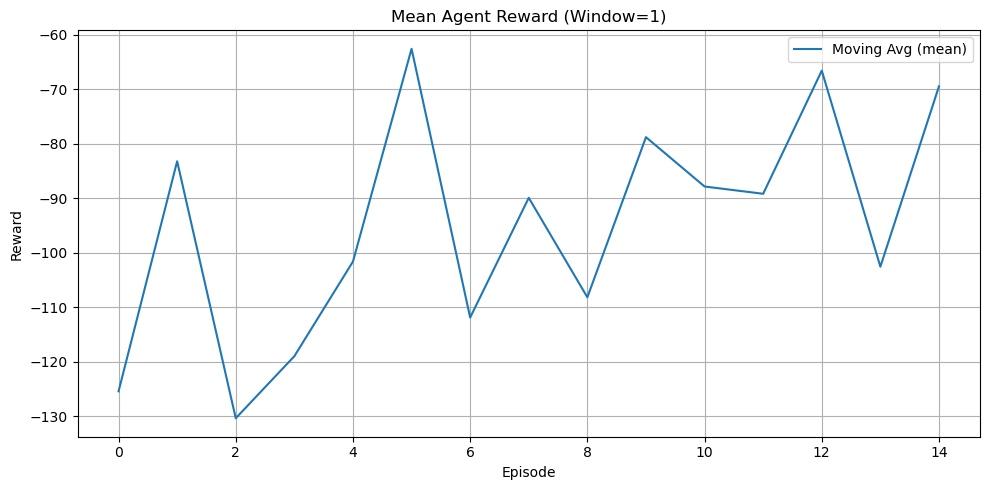


--- Processing Group: emotion=average, see_emotions=True, alpha=0.5, beta=0.5, smoothing=linear, threshold=0.5, rounder=2, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=16, hidden_size=64, update_target_every=5 ---


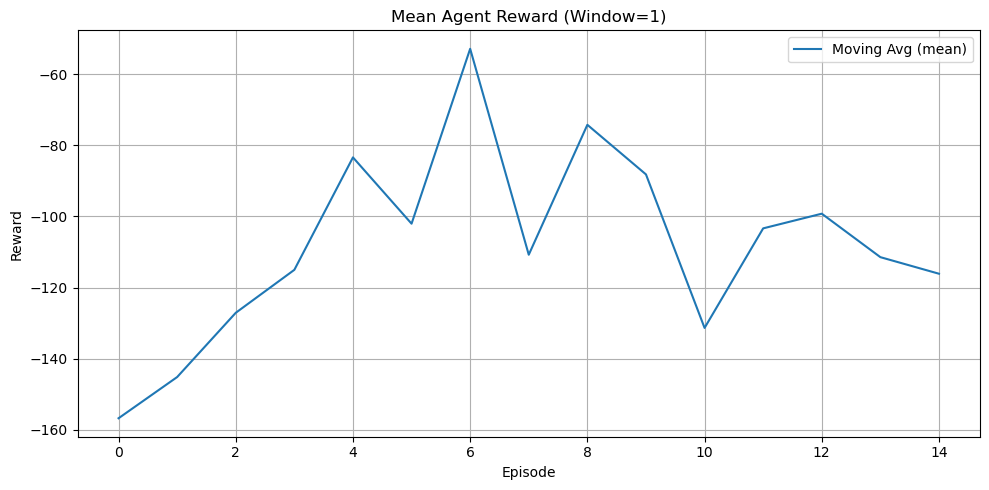

In [ ]:
core_params = [
    'emotion', 'see_emotions', 'alpha', 'beta', 'smoothing', 'threshold', 'rounder',
    'learning_rate', 'gamma', 'epsilon', 'epsilon_decay', 'epsilon_min',
    'batch_size', 'hidden_size', 'update_target_every'
]

df = df_gt_summary  # Choice of the summary dataframe to test : 

for param_values, group in df.groupby(core_params):
    label = ', '.join(f"{k}={v}" for k, v in zip(core_params, param_values))
    print(f"\n--- Processing Group: {label} ---")

    windowed_df = windowed_avg_combined_reward(
        df=group,
        reward_prefix="total_combined_reward",
        episode_column="episode",
        simulation_id_column="simulation_index", 
        window_size=1,
        aggregation_mode="mean", # can be best or mean
        plot=True
    )

## Data Vizualization

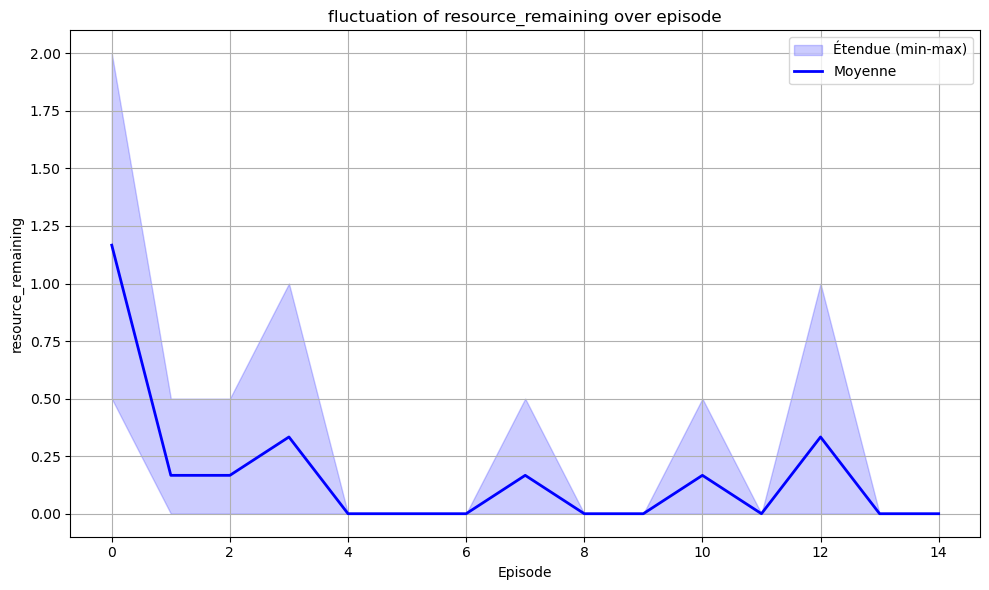

In [30]:
df = df_gt_summary
fluctuating_variable = 'resource_remaining'
period_type = 'episode'

# not to change
is_step_csv = (period_type == 'step')

# Potentially improve for larger episode number
plot_mean_and_range_across_simulations(
    df=df, 
    value_col=fluctuating_variable, 
    is_step_csv=is_step_csv, 
    title=f'fluctuation of {fluctuating_variable} over {period_type}'
)


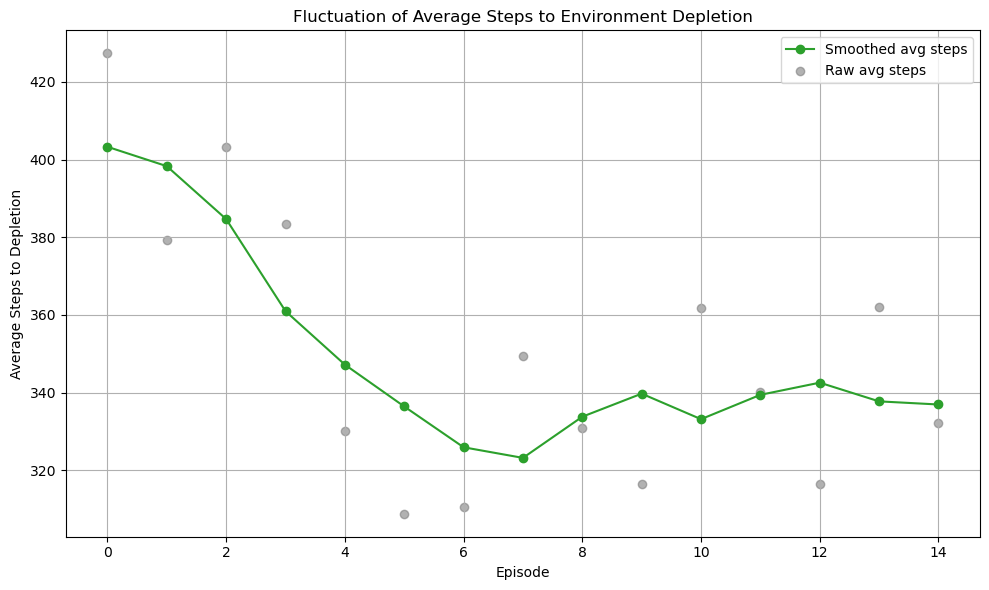

In [31]:
# Plot density function of the proportion of depletion
# Potentially improve for larger episode number
plot_avg_steps_to_depletion(df_gt_summary, steps_col='total_steps')

## Data Analysis

In [32]:
# Stats : t-test to compare the empathic comparisons

# Summary